Today, we’re going to build something fast and easy, and check out a way to quickly compile and clean a dataset gathered from the Bing Image Search API. This fish classifier is built using Pytorch and FastAI, and reaches 93% accuracy using a very small dataset, only 380 images in total. This classifier can differentiate between fish that belong on coral reefs, freshwater, or in the deep ocean. Let’s dive in!

![Angelfish live on coral reefs.](angelfish.jpg)

## Pre-planning

Before we dive straight in to model building, let's think like an engineer. What do we actually want to accomplish?

1. **Define the objective** – We want to build a model that can classify images into deep sea, reef, or freshwater fish. Not just the ones in our dataset, but any fish picture we throw at it. 
2. **What actions can we take?** – We can gather a dataset of fish images, clean it up so it's not full of junk, and train a model to be as accurate as possible. 
3. **What data do we have?** – The internet is full of fish pictures! We'll use Bing’s image search API to scrape some and build our own dataset.

## Gathering a Dataset

First, let’s grab some fish pictures from Bing.

In [2]:
from fastai.vision.all import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'my_api_key')  # insert key value here
path = Path("fish")

SEARCH_TERMS = ["deep sea fish", "freshwater fish", "reef fish"]
for o in SEARCH_TERMS:
    dest = path/o
    if not os.path.exists(dest):
        os.makedirs(dest)
        results = search_images_bing(key, o)
        download_images(dest, urls=results.attrgot('contentUrl')) # dest is a path object 

Great, now we have folders full of images. But the internet is messy— some of these are probably not fish, some might be mislabeled, and some might be totally useless. We need to clean up.

## Cleaning the dataset

Instead of going through them by hand (boring! slow!), we’ll train a quick classifier to help us sort out the bad ones. First we can remove any obviously broken files.

In [ ]:
fns = get_image_files(path)  # finds all image files in path and subpaths
failed = verify_images(fns)
failed.map(Path.unlink)

Then train a quick model to help us clean the rest.

In [6]:
dls = ImageDataLoaders.from_path_func(path, 
                                      get_image_files(path), 
                                      parent_label, 
                                      seed=42,
                                      item_tfms=RandomResizedCrop(224, min_scale=0.5),
                                      batch_tfms=aug_transforms())

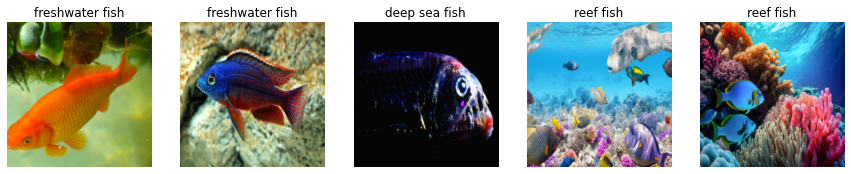

In [7]:
dls.valid.show_batch(max_n=5, nrows=1)

In [8]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.648003,0.747909,0.671053,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.796192,0.540283,0.776316,00:16
1,0.682664,0.470164,0.815789,00:16
2,0.550159,0.427897,0.828947,00:16


Let’s use this model to find the images it’s most confused about. Those images are likely misclassified or just bad images.

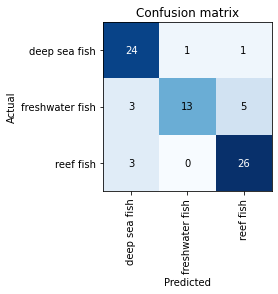

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

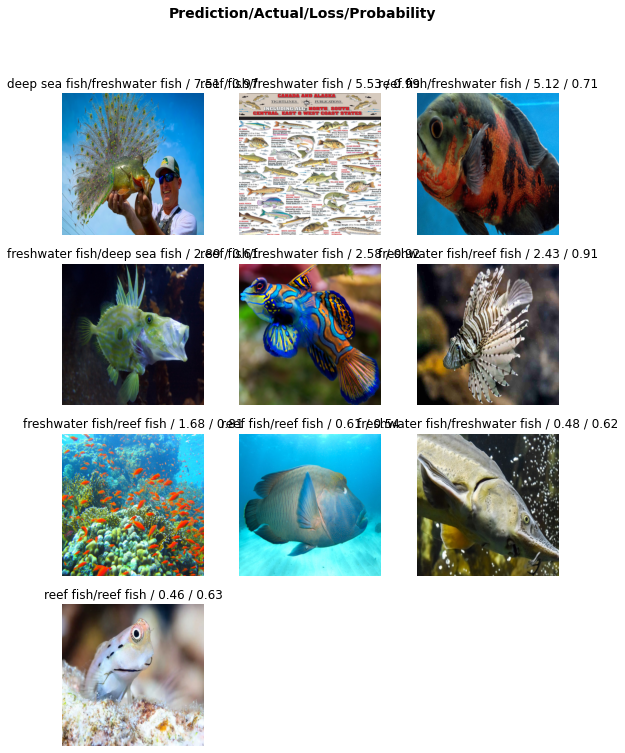

In [30]:
interp.plot_top_losses(10, nrows=4)

In [11]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

This pulls up an interactive widget where we can delete the bad images or move them to the correct category. 

![ImageClassifierCleaner](imageClassifierCleaner.png)

In [21]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Boom! Dataset cleaned. Now we can train the real model.

## Experimenting with the model

Now that we have a solid dataset, we can first build a baseline model and then experiment with hyperparameters. 

### Baseline Model

In [22]:
### Experiment 1: Baseline
dls = ImageDataLoaders.from_path_func(path, 
                                      get_image_files(path), 
                                      parent_label, 
                                      seed=42,
                                      item_tfms=RandomResizedCrop(224, min_scale=0.5),
                                      batch_tfms=aug_transforms())
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,2.110603,0.928864,0.636364,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.876281,0.530159,0.779221,00:14
1,0.707189,0.526176,0.831169,00:12
2,0.625902,0.444526,0.857143,00:12


This gives us a good starting point, but we can do better! 

### Larger Image Size

Maybe the model just needs to see more details in the fish.

In [23]:
### Experiment 2: Larger images
dls = ImageDataLoaders.from_path_func(path, 
                                      get_image_files(path), 
                                      parent_label, 
                                      seed=42,
                                      item_tfms=RandomResizedCrop(500, min_scale=0.5),
                                      batch_tfms=aug_transforms())
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.968835,0.604990,0.792208,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.743671,0.430460,0.818182,00:19
1,0.598641,0.391256,0.857143,00:18
2,0.471975,0.371211,0.857143,00:18


Continuing on, we can play other hyperparameters like with min_scale value, try some deeper or different model architectures, and finally train to overfitting to discover the best number of epochs to train for. Once we’re happy, we save our model for future use.

## Save the final model

In [8]:
### Final Model
dls = ImageDataLoaders.from_path_func(path, 
                                      get_image_files(path), 
                                      parent_label, 
                                      seed=42,
                                      item_tfms=RandomResizedCrop(500, min_scale=0.75),
                                      batch_tfms=aug_transforms())
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.615644,0.802557,0.644737,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.800859,0.560063,0.736842,00:21
1,0.667470,0.369439,0.828947,00:21
2,0.520393,0.288026,0.907895,00:22
3,0.423325,0.282853,0.921053,00:20
4,0.363907,0.296785,0.934211,00:20


In [9]:
learn.export()

We cleaned the dataset and gained significantly in accuracy, hitting 93% on a model trained on only 380 images. If we choose, we can gain rapidly in accuracy by spending a bit more time adding to and continuing to clean the dataset. 

